In [1]:
import argparse
import torch
import torchvision.transforms as transforms
from flask import Flask, jsonify, request
from PIL import Image
import io
import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'model.pth'

In [3]:
dict_genres = {0: 'Horreur', 1: 'Animation', 2: 'Action', 3: 'Fantasy', 4: 'Science-Fiction', 5: 'Thriller', 6: 'Drama', 7: 'Romance', 8: 'Comedy', 9: 'Documentary'}
num_classes = len(dict_genres)

# LOAD THE MODEL
model_genre = torchvision.models.resnet18()
model_genre.fc = torch.nn.Linear(in_features=512, out_features=num_classes)
model_genre.to(device)

# Load the model
model_genre.load_state_dict(torch.load(model_path, map_location=device))
model_genre.eval()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL ultralytics.nn.tasks.ClassificationModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ClassificationModel])` or the `torch.serialization.safe_globals([ClassificationModel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [4]:
#means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
means, stds = (0.5,), (0.5,)
transform_xai = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def get_imagenette2_loaders(root_path='./Dataset/MovieGenre/content/sorted_movie_posters_paligema', **kwargs):

    dataset_xai = torchvision.datasets.ImageFolder(root_path, transform=transform_xai)
    loader_xai = torch.utils.data.DataLoader(dataset_xai, **kwargs)
    return loader_xai

loader_xai = get_imagenette2_loaders(batch_size=64, shuffle=True, num_workers=2)

In [5]:
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(means, stds)],
   std= [1/s for s in stds]
)

(-0.5, 223.5, 223.5, -0.5)

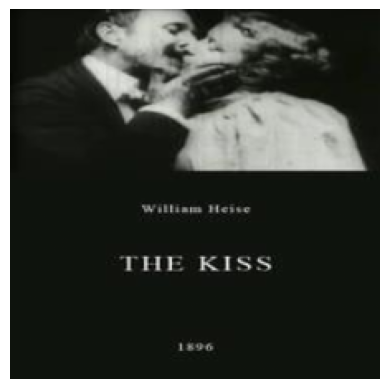

In [14]:
x, _ = next(iter(loader_xai))
idx = 0

img = x[idx]
np_img = np.transpose(inv_normalize(img).cpu().detach().numpy(), (1,2,0))
plt.imshow(np_img)
plt.axis('off')

In [15]:
img = img.unsqueeze(0).cuda() # we need to set the input on GPU before the requires_grad operation!
img.requires_grad_();

In [16]:
output = model_genre(img)
output_idx = output.argmax()
output_max = output[0, output_idx]

output_max.backward()

In [17]:
dict_genres[int(output_idx)]

'Romance'

### **Vanilla gradient back-propagation**

(-0.5, 223.5, 223.5, -0.5)

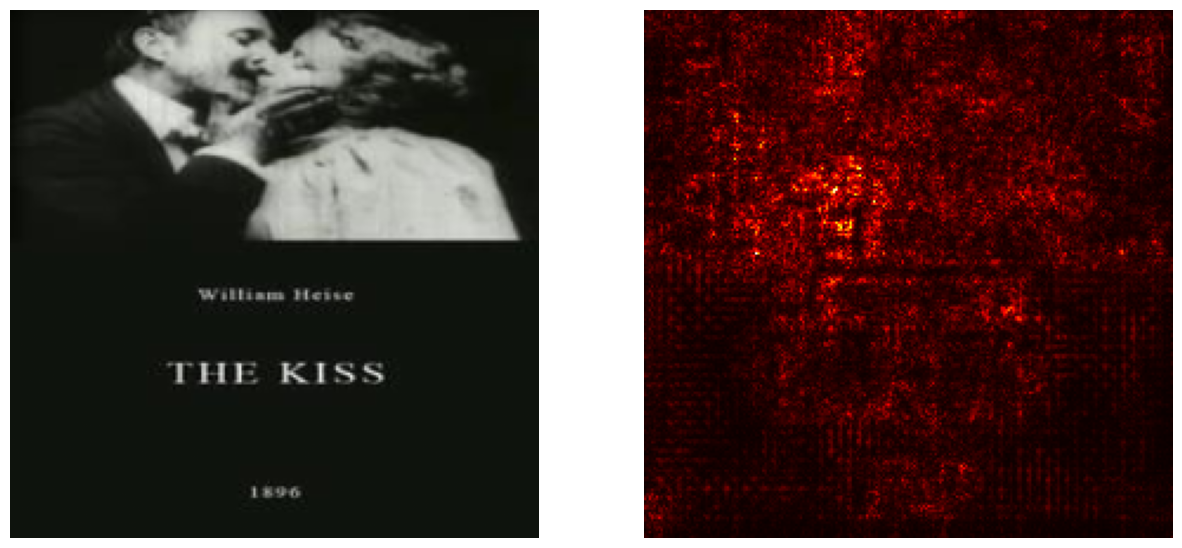

In [18]:
saliency, _ = torch.max(img.grad.data.abs(), dim=1)
saliency = saliency.squeeze(0)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')


##### **Smooth grad (averaging the saliency map)**

In [19]:
def get_vanilla_grad(img, model):
    img = img.clone().detach().requires_grad_(True)  # S'assurer que les gradients sont traçables

    model.eval()  # Mettre le modèle en mode évaluation
    output = model(img)  # Propagation avant

    # On suppose que l'on prend la classe prédite (logit max)
    pred_class = output.argmax(dim=1)
    selected_output = output[0, pred_class]

    selected_output.backward()  # Calcul du gradient en backpropagation

    return img.grad  # Retourner le gradient de l’image

(-0.5, 223.5, 223.5, -0.5)

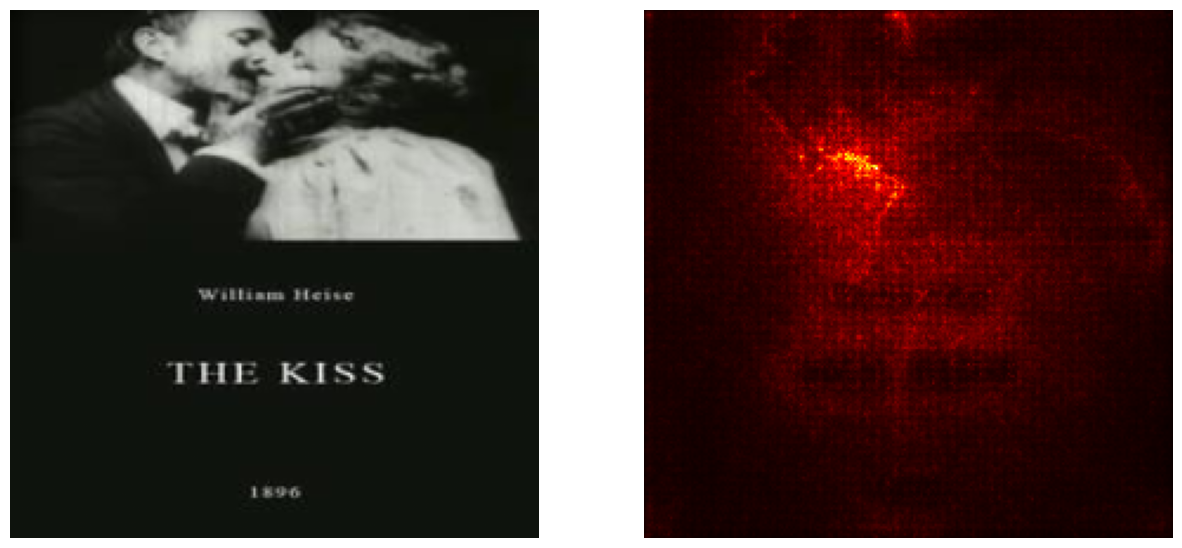

In [20]:
import numpy as np

stdev_spread=0.15
n_samples=100
stdev = stdev_spread * (img.max() - img.min())
total_gradients = torch.zeros_like(img, device='cuda')

for i in range(n_samples):
    noise = np.random.normal(0, stdev.item(), img.shape).astype(np.float32)
    noisy_img = img + torch.tensor(noise, device='cuda', requires_grad=True)
    grad= get_vanilla_grad(noisy_img, model_genre)
    total_gradients += grad * grad #using the square of the gradients generates smoother visualizations
    #total_gradients += grad
total_gradients /= n_samples

saliency, _ = torch.max(total_gradients.abs(), dim=1)
saliency = saliency.squeeze(0)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')

### **Grad-CAM**

In [21]:
class HookFeatures():
    def __init__(self, module):
        self.feature_hook = module.register_forward_hook(self.feature_hook_fn)
    def feature_hook_fn(self, module, input, output):
        self.features = output.clone().detach()
        self.gradient_hook = output.register_hook(self.gradient_hook_fn)
    def gradient_hook_fn(self, grad):
        self.gradients = grad
    def close(self):
        self.feature_hook.remove()
        self.gradient_hook.remove()

In [22]:
print(model_genre)
hook = HookFeatures(model_genre.layer4)         # MODIF : remplacement de features[19] en layer4

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
output = model_genre(img)
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

gradients = hook.gradients
activations = hook.features
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # we take the average gradient of every chanels
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i] # we multiply every chanels of the feature map with their corresponding averaged gradients

In [24]:
dict_genres[int(output_idx)]

'Romance'

(-0.5, 223.5, 223.5, -0.5)

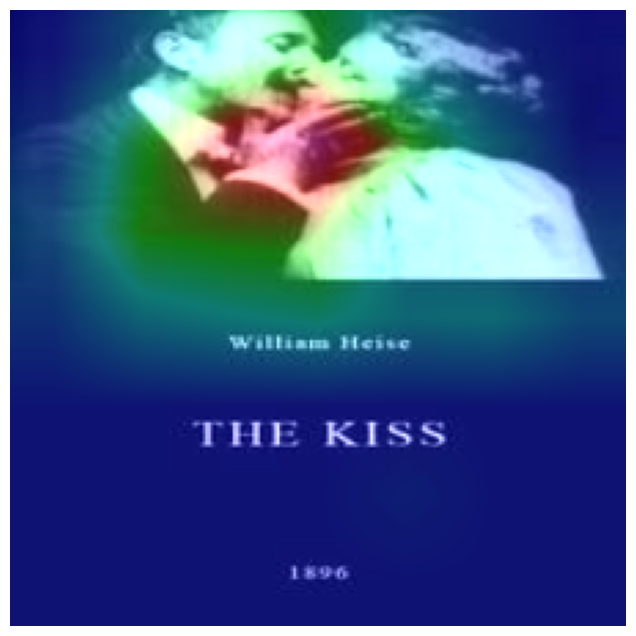

In [25]:
import cv2

heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.maximum(heatmap.detach().cpu(), 0)
heatmap /= torch.max(heatmap)
heatmap = cv2.resize(np.float32(heatmap), (img.shape[2], img.shape[3]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW) / 255
superposed_img = (heatmap) * 0.4 + np_img
plt.figure(figsize=(8,8))
plt.imshow(np.clip(superposed_img,0,1))
plt.axis('off')

In [26]:
hook.close()

### **Captum**

In [27]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import visualization as viz

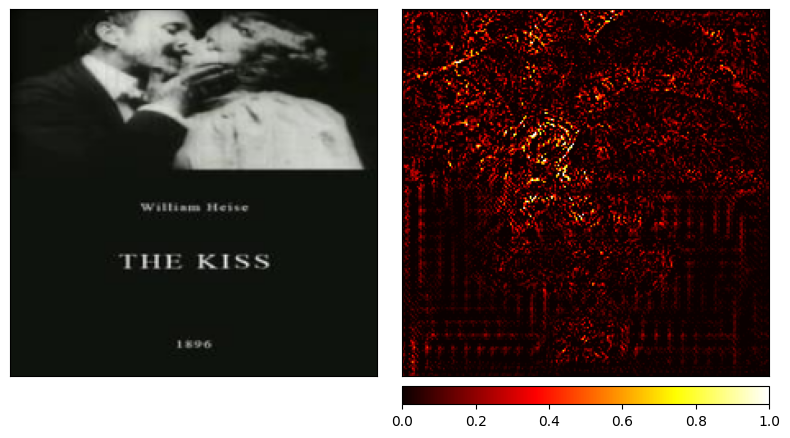

In [28]:
def plot_heatmap(attributions, img):
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(inv_normalize(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap='hot',
                              show_colorbar=True)

# Integradted gradients (https://arxiv.org/abs/1703.01365)
integrated_gradients = IntegratedGradients(model_genre)
attributions = integrated_gradients.attribute(img, target=output_idx, n_steps=200, internal_batch_size=1)

plot_heatmap(attributions, img)

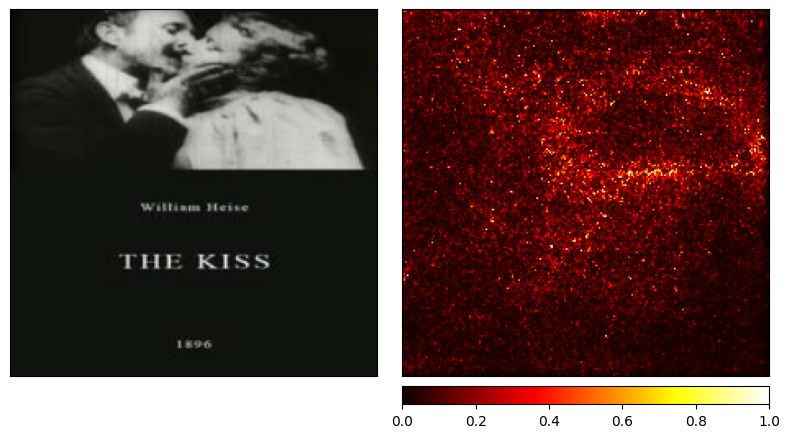

In [29]:
#Noise tunnel (SmoothGrad, VarGrad: https://arxiv.org/abs/1810.03307)
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions = noise_tunnel.attribute(img, nt_samples_batch_size=1, nt_samples=10, nt_type='smoothgrad_sq', target=output_idx)

plot_heatmap(attributions, img)

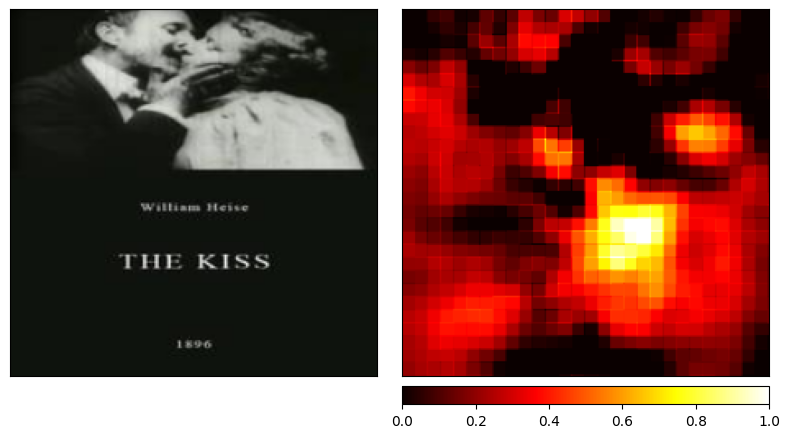

In [30]:
#Occlusion (https://arxiv.org/abs/1311.2901)
occlusion = Occlusion(model_genre)
attributions = occlusion.attribute(img,
                                  strides = (3, 8, 8),
                                  target=output_idx,
                                  sliding_window_shapes=(3,15, 15),
                                  baselines=0)

plot_heatmap(attributions, img)

In [31]:
#DeepLift (https://arxiv.org/pdf/1704.02685.pdf)
dl = DeepLift(model_genre)
attributions = dl.attribute(img, target=output_idx, baselines=img * 0)

plot_heatmap(attributions, img)

/home/n7student/miniforge3/envs/env_tensorboard/lib/python3.12/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


RuntimeError: A Module ReLU(inplace=True) was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

/home/n7student/miniforge3/envs/env_tensorboard/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


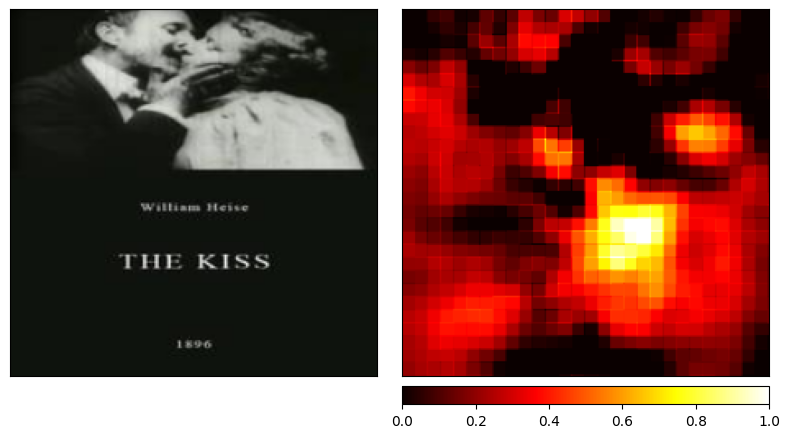

In [32]:
#Guided Grad-CAM (https://arxiv.org/abs/1610.02391)
guided_gc = GuidedGradCam(model_genre, model_genre.layer4)   # MODIF : remplacement de features[19] en layer4
attribution = guided_gc.attribute(img, target=output_idx)
plot_heatmap(attributions, img)

### **Feature visualization**

In [33]:
class FeaturesHook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

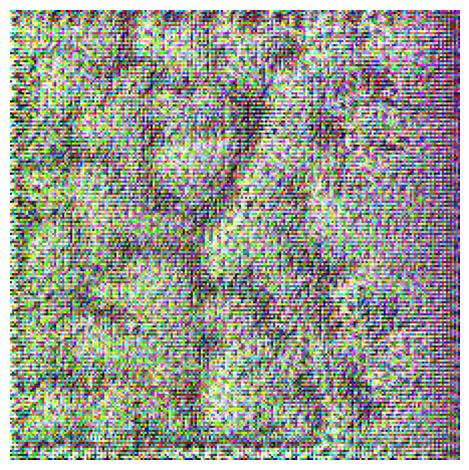

In [48]:
def visualize_feature(model, channel_idx):                       # MODIF : retrait du deuxième paramètre : layer_idx
  img = torch.rand((1,3,224,224), requires_grad=True, device="cuda") #initialize a random image
  optimizer = torch.optim.Adam([img], lr=0.1, weight_decay=1e-6)
  features_hook =  FeaturesHook(model.layer1[1].conv2) # hook the desired layer      # MODIF : remplacement de features[19] en layer1, ...
  for n in range(512):
        optimizer.zero_grad()
        model(img) #forward pass
        features_map = features_hook.features
        # We normalize the features before computing the loss
        normalized_features = features_map / (torch.sqrt(torch.mean(torch.square(features_map))) + 1e-5)

        # Goal is to maximize the normalized channel's output
        loss = -normalized_features[0, channel_idx].mean()
        loss.backward()
        optimizer.step()

  features_hook.close()
  img = img.squeeze(0)
  img = inv_normalize(img).cpu().detach().numpy()
  img = np.transpose(img, (1,2,0))
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  plt.axis('off')
  plt.tight_layout()

#visualize layer one channel 2
visualize_feature(model_genre, 3)                               # MODIF : retrait du deuxième paramètre : layer_idx à 1